# Extension Plan - Forecasting

This notebook analyzes the impact of smoke generated from wildfires on health within a 650-mile radius of Mesa, AZ. In this notebook, I use the VARMAX model to forecast how smoke estimates affect the different health indicators in the next 25 years. I utilize the previously forecasted smoke estimates to aid with this prediction. 

In [8]:
#
#    IMPORTS
#

#    These are standard python modules. In case you do not have a python module, you should use `!pip install <module>`
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
import numpy as np


First, I load all the required data and create a single table out of it to help with the modelling

In [9]:

mortality_data = pd.read_csv("../Processed Data/1999_2020_Mortality_Data.csv")
smoke_estimate_aqi_data = pd.read_csv("../Processed Data/smoke_estimate_with_year_aqi.csv", index_col=0)
respiratory_therapy_data = pd.read_csv("../Processed Data/2000_2015_respiratory_therapy.csv")
respiratory_operations_data = pd.read_csv("../Processed Data/2000_2020_respiratory_system_operations.csv")
emergency_visit_data = pd.read_csv("../Processed Data/2003_2021_emergency_visits_data.csv")
inpatient_discharges_data = pd.read_csv("../Processed Data/2003_2021_inpatient_discharge_data.csv")
smoke_predictions = pd.read_csv("../Processed Data/smoke_estimate_predictions.csv")


Next, we perform a basic clean up and formatting of the data to help with the forcasting

In [10]:
mortality_aggregated_by_year = mortality_data.groupby('Year').agg({'Deaths': 'sum'}).reset_index()
mortality_aggregated_by_year.rename(columns={'Deaths': 'Respiratory Mortality'}, inplace=True)

smoke_estimate_aqi_data.rename(columns={'Fire_Year': 'Year'}, inplace=True)
respiratory_therapy_data.rename(columns={'Total': 'Procedures - Respiratory Therapy'}, inplace=True)
respiratory_operations_data.rename(columns={'Total': 'Procedures - Respiratory Operations'}, inplace=True)
emergency_visits_aggregated_by_year = emergency_visit_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
emergency_visits_aggregated_by_year.rename(columns={'Asthma, All Mentions': 'Emergency Visits - Asthma All Mentions'}, inplace=True)
inpatient_discharges_aggregated_by_year = inpatient_discharges_data.groupby('Year').agg({'Asthma, All Mentions': 'sum'}).reset_index()
inpatient_discharges_aggregated_by_year.rename(columns={'Asthma, All Mentions': 'Inpatient Discharges - Asthma All Mentions'}, inplace=True)

Now, we merge all the datasets by year to make it easier to use

In [11]:
# Merging the dataframes
dfs = [smoke_estimate_aqi_data, mortality_aggregated_by_year, respiratory_therapy_data, respiratory_operations_data, emergency_visits_aggregated_by_year, inpatient_discharges_aggregated_by_year]
result = dfs[0]

for df in dfs[1:]:
    result = pd.merge(result, df, on='Year', how='outer')

result


,Year,Smoke_Estimate,yearly_avg_aqi,Respiratory Mortality,Procedures - Respiratory Therapy,Procedures - Respiratory Operations,Emergency Visits - Asthma All Mentions,Inpatient Discharges - Asthma All Mentions
0,1964,4.341713,5.386648,NaN,NaN,NaN,NaN,NaN
1,1965,4.000000,6.132075,NaN,NaN,NaN,NaN,NaN
2,1966,6.274285,4.641221,NaN,NaN,NaN,NaN,NaN
3,1967,7.693339,53.584158,NaN,NaN,NaN,NaN,NaN
4,1968,6.949404,63.722527,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
56,2020,64.000000,45.770657,3239.0,NaN,20724.0,63167.0,29521.0
57,2021,NaN,47.492489,NaN,NaN,NaN,57088.0,30799.0
58,2022,NaN,40.919786,NaN,NaN,NaN,NaN,NaN
59,2023,NaN,44.967453,NaN,NaN,NaN,NaN,NaN


Now, since most of the health indicators data is between 1999 and 2020, I filter the data to those years

In [12]:
result_filtered = result[(result['Year'] >= 1999) & (result['Year'] <= 2020)]
result_filtered['Year'] = pd.to_datetime(result_filtered['Year'], format='%Y')
result_filtered

C:\Users\mihir\AppData\Local\Temp\ipykernel_24992\3700230279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_filtered['Year'] = pd.to_datetime(result_filtered['Year'], format='%Y')


,Year,Smoke_Estimate,yearly_avg_aqi,Respiratory Mortality,Procedures - Respiratory Therapy,Procedures - Respiratory Operations,Emergency Visits - Asthma All Mentions,Inpatient Discharges - Asthma All Mentions
35,1999-01-01,20.482623,54.849141,2434.0,NaN,NaN,NaN,NaN
36,2000-01-01,27.482062,51.371458,2457.0,6788.0,7964.0,NaN,NaN
37,2001-01-01,21.431882,49.290578,2379.0,7220.0,8953.0,NaN,NaN
38,2002-01-01,21.553465,53.063240,2443.0,7801.0,9507.0,NaN,NaN
39,2003-01-01,22.090325,53.228136,2364.0,10682.0,10061.0,15395.0,10057.0
40,2004-01-01,18.821474,45.149172,2245.0,9819.0,10951.0,32405.0,21050.0
41,2005-01-01,32.035572,47.915494,2641.0,11796.0,11804.0,42054.0,23037.0
42,2006-01-01,38.829661,47.896634,2487.0,12290.0,12709.0,44403.0,23588.0
43,2007-01-01,30.907773,47.032512,2215.0,12970.0,13075.0,45697.0,24349.0
44,2008-01-01,29.935974,47.256230,2428.0,14531.0,13985.0,52785.0,26121.0


Now, I work on the VARMAX model.
I’ve specifically chosen the VARMAX (Vector Autoregression Moving-Average with eXogenous variables) model for this analysis because it’s well-suited for handling multiple time series that influence each other. By using a multivariate approach, I can account for the relationships between health metrics and their own past values, allowing for a deeper understanding of trends and interactions over time.

Note: Since I am using the VARMAX model, I need to ensure that all the historical data for the endog (target) variable is consisent and exists for all years 1999 - 2020. In order to ensure this, I use the imputer model to add any missing data. I used ChatGPT to help me with the missing data and code for it.

c:\Users\mihir\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


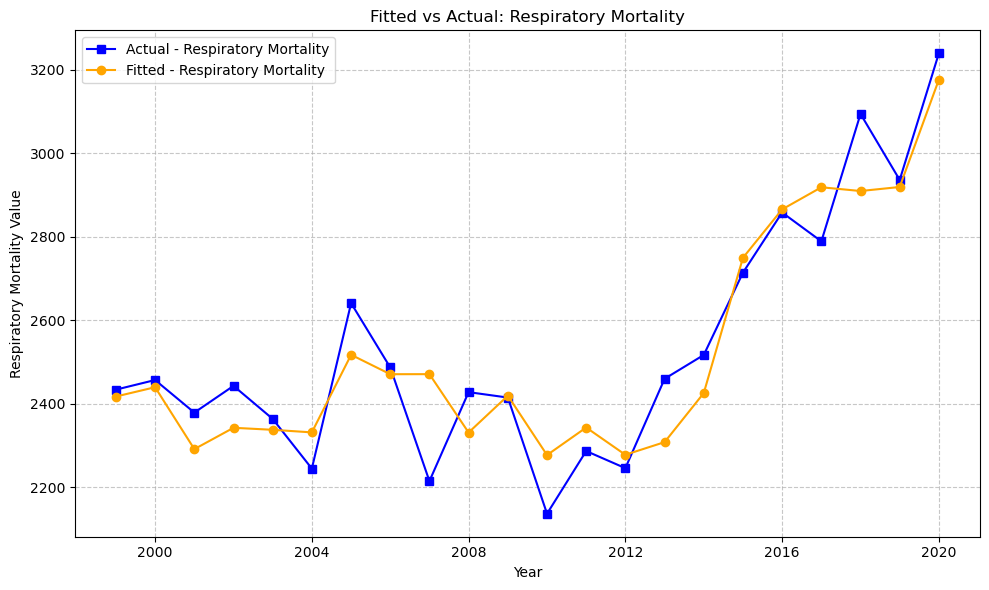

Respiratory Mortality - RMSE: 101.92, Relative RMSE: 4.02%



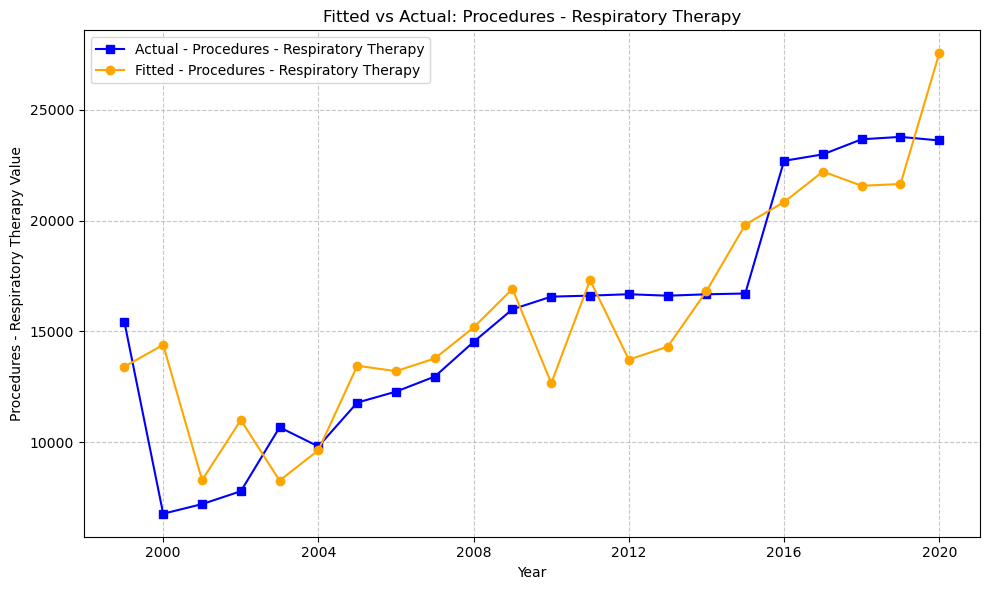

Procedures - Respiratory Therapy - RMSE: 2632.12, Relative RMSE: 16.94%



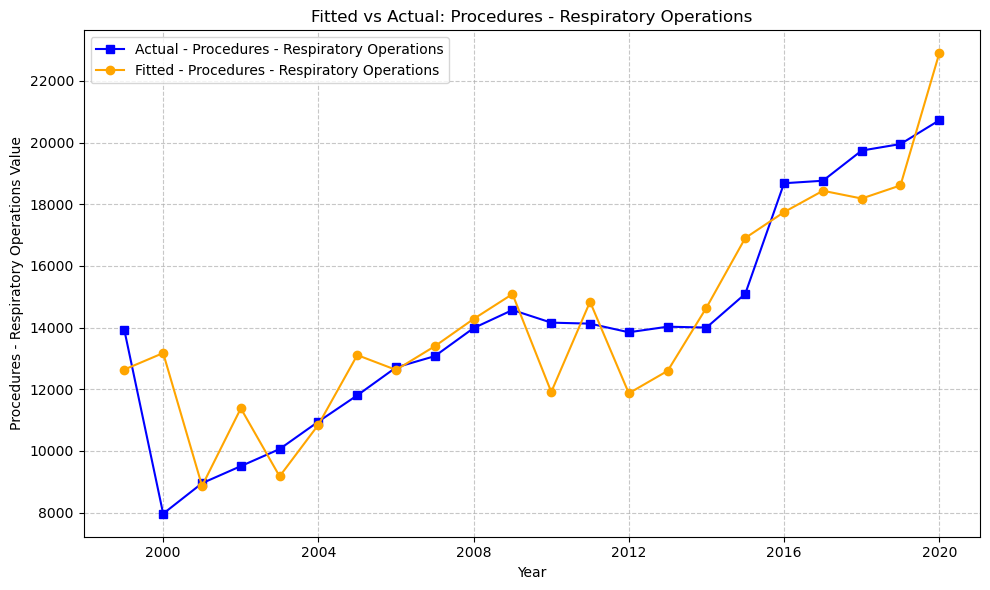

Procedures - Respiratory Operations - RMSE: 1656.96, Relative RMSE: 11.74%



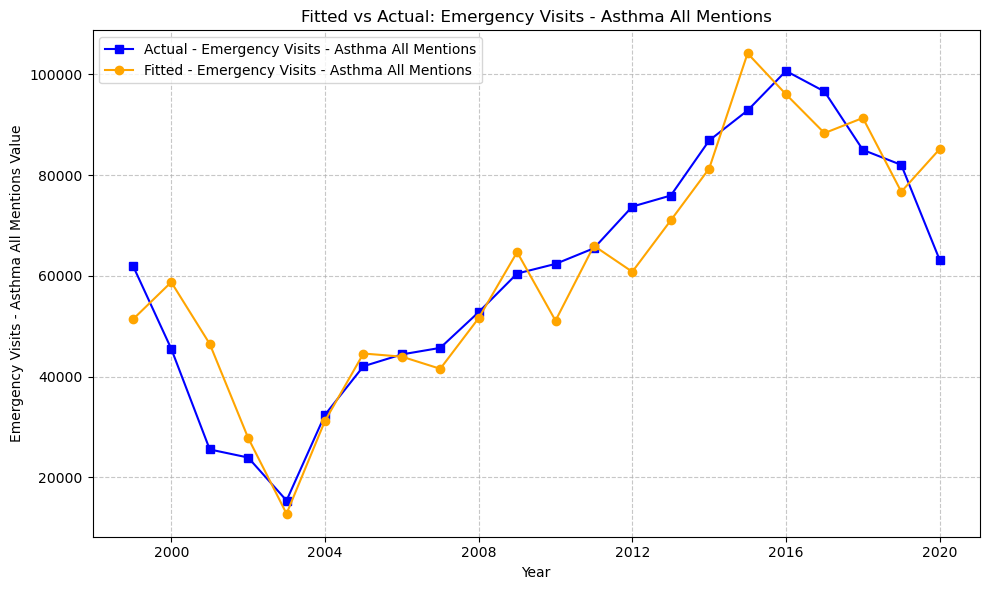

Emergency Visits - Asthma All Mentions - RMSE: 9329.37, Relative RMSE: 15.38%



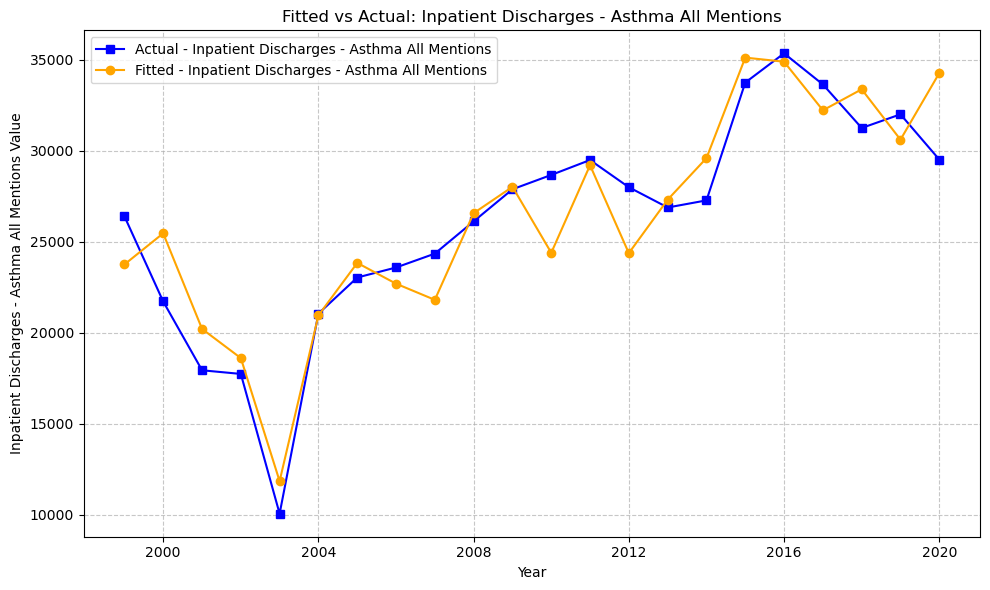

Inpatient Discharges - Asthma All Mentions - RMSE: 2220.83, Relative RMSE: 8.49%



In [13]:
# Define endogenous (target) and exogenous (predictor) variables
endog = result_filtered[['Respiratory Mortality', 'Procedures - Respiratory Therapy', 
                         'Procedures - Respiratory Operations', 'Emergency Visits - Asthma All Mentions', 
                         'Inpatient Discharges - Asthma All Mentions']]
exog = result_filtered[['Smoke_Estimate']]

# Define the imputer model
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values in the endogenous variables using IterativeImputer
endog_imputed = pd.DataFrame(imputer.fit_transform(endog), columns=endog.columns, index=endog.index)

# Standardize endogenous variables
scaler = StandardScaler()
endog_scaled = pd.DataFrame(scaler.fit_transform(endog_imputed), 
                            columns=endog_imputed.columns, 
                            index=endog_imputed.index)

# Fit the VARMAX model
model = VARMAX(endog_scaled, exog=exog, order=(1, 2))
fitted_model = model.fit(disp=False)
fitted_values = fitted_model.fittedvalues

# Inverse transform fitted and actual values to original scale
fitted_values_original = pd.DataFrame(scaler.inverse_transform(fitted_values), 
                                      columns=endog_imputed.columns, 
                                      index=endog_imputed.index)
endog_original = pd.DataFrame(scaler.inverse_transform(endog_scaled), 
                              columns=endog_imputed.columns, 
                              index=endog_imputed.index)

year_column = result_filtered['Year'].reset_index(drop=True)  # Ensure alignment

# Plot fitted vs actual for each indicator
for column in endog_imputed.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(year_column, endog_original[column], label=f'Actual - {column}', color='blue', marker='s')
    plt.plot(year_column, fitted_values_original[column], label=f'Fitted - {column}', color='orange', marker='o')
    plt.title(f'Fitted vs Actual: {column}')
    plt.xlabel('Year')
    plt.ylabel(f'{column} Value')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # RMSE Evaluation
    rmse = np.sqrt(mean_squared_error(endog_original[column], fitted_values_original[column]))
    relative_rmse = rmse / endog_original[column].mean()
    print(f"{column} - RMSE: {rmse:.2f}, Relative RMSE: {relative_rmse:.2%}")
    print("\n================================================================================================")         

Looking at the relative RMSE scores, we can see that the model is performing well and is well fitted to the historic data.

Next, I utilize the previously predicted smoke estimates along side the historic information about health indictors to predict the trends in health data from 2021 - 2050.

c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation 

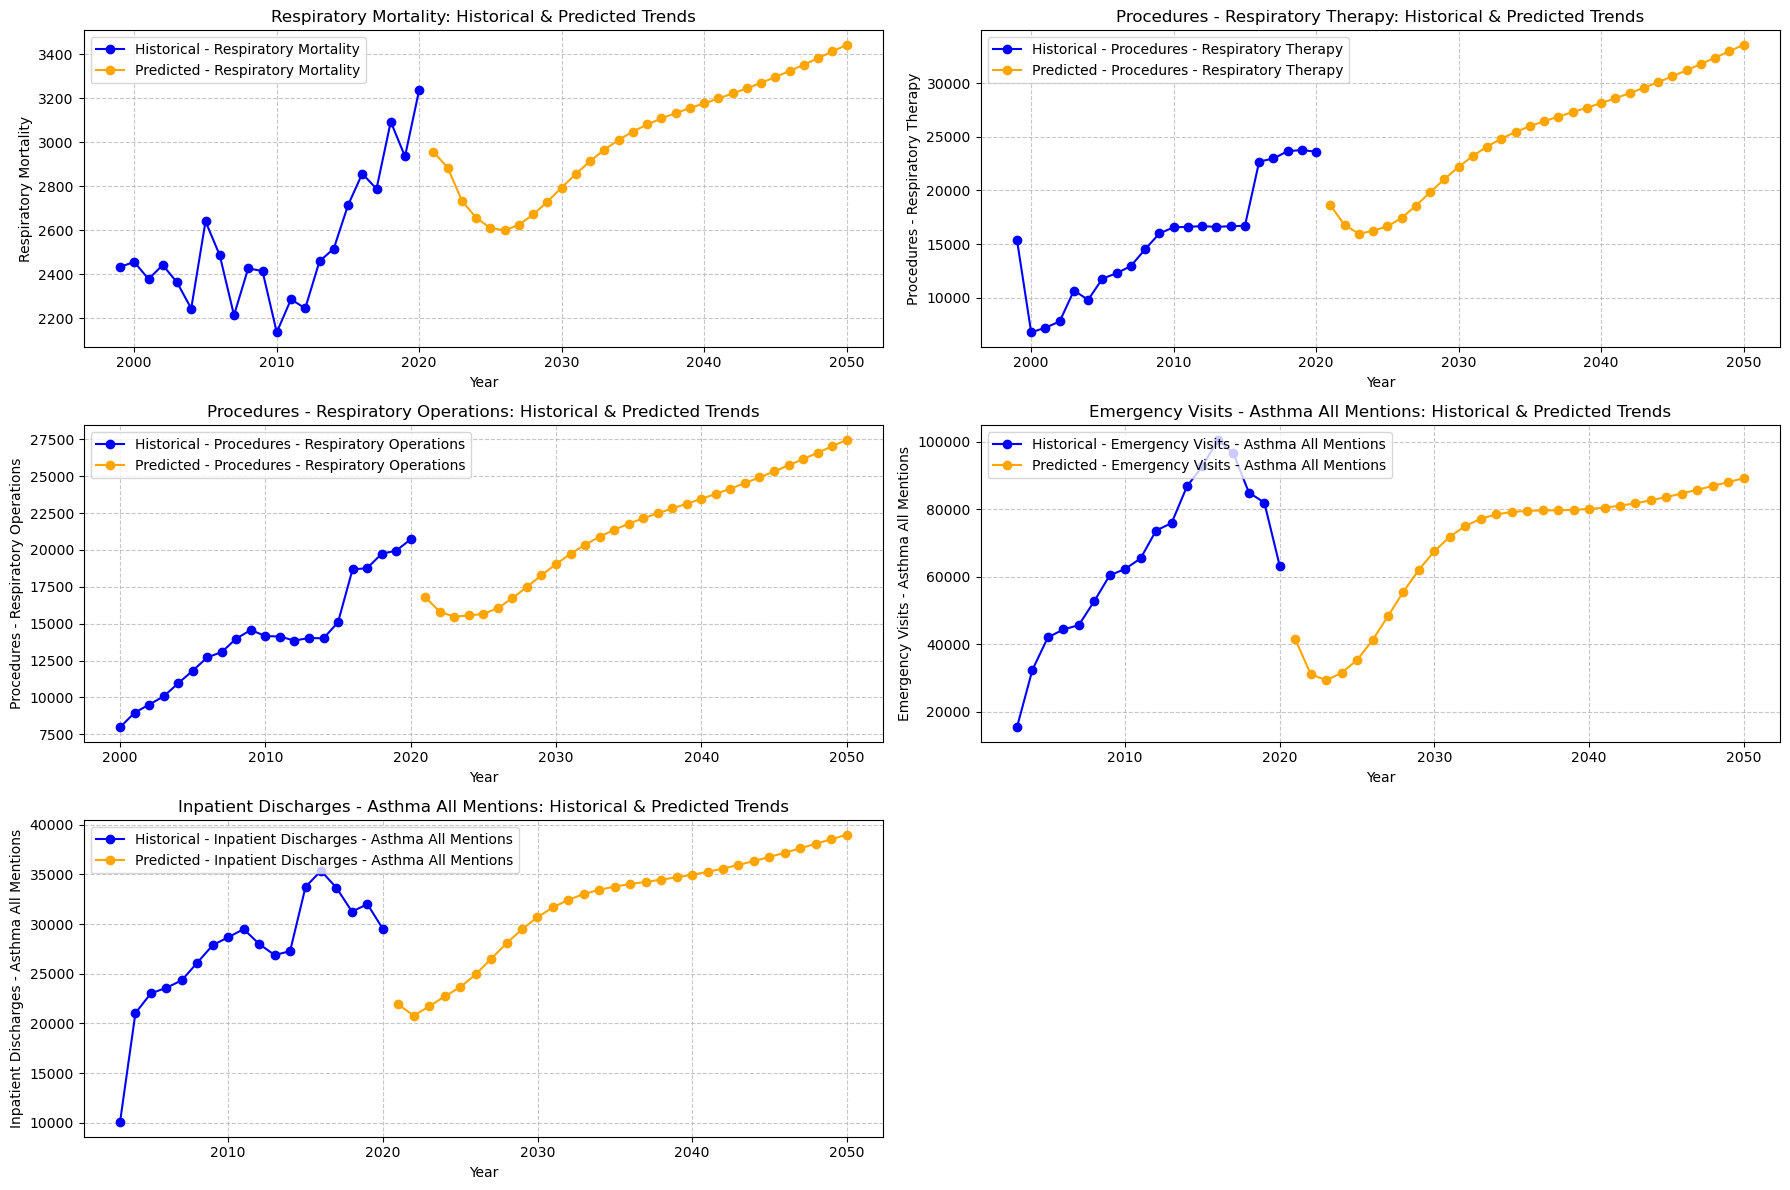

In [14]:

# Prepare exogenous data for predictions
exog_new = smoke_predictions[['Smoke_Estimate']]

# Define historical_df by filtering result_filtered for the historical period
historical_df = result_filtered.copy()

historical_df['Procedures - Respiratory Therapy'] = endog_imputed['Procedures - Respiratory Therapy']

# Predict future values
predictions = fitted_model.get_forecast(steps=len(exog_new), exog=exog_new)
predicted_values = predictions.predicted_mean

# Inverse transform predictions to original scale
predicted_values_original = scaler.inverse_transform(predicted_values)
predicted_df = pd.DataFrame(predicted_values_original, 
                            columns=endog_imputed.columns)

# Correct the predicted years to start after the last historical year
predicted_df['Year'] = pd.date_range(
    start=historical_df['Year'].iloc[-1],
    periods=len(predicted_df),
    freq='Y'
)

# Combine historical and predicted data
combined_dfs = []
for column in endog_imputed.columns:
    combined_df = pd.DataFrame({
        'Year': pd.concat([historical_df['Year'], predicted_df['Year']], ignore_index=True),
        'Values': pd.concat([historical_df[column], predicted_df[column]], ignore_index=True),
        'Type': ['Historical'] * len(historical_df) + ['Predicted'] * len(predicted_df)
    })
    combined_dfs.append(combined_df)

# Plot combined data for each indicator
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, column in enumerate(endog_imputed.columns):
    ax = axes[i]
    combined_df = combined_dfs[i]
    
    # Plot historical data
    ax.plot(
        combined_df.loc[combined_df['Type'] == 'Historical', 'Year'],
        combined_df.loc[combined_df['Type'] == 'Historical', 'Values'],
        label=f'Historical - {column}',
        color='blue',
        marker='o'
    )
    
    # Plot predicted data
    ax.plot(
        combined_df.loc[combined_df['Type'] == 'Predicted', 'Year'],
        combined_df.loc[combined_df['Type'] == 'Predicted', 'Values'],
        label=f'Predicted - {column}',
        color='orange',
        marker='o'
    )
    
    ax.set_title(f'{column}: Historical & Predicted Trends')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'{column}')
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)

# Remove extra subplot if necessary
if len(endog_imputed.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [15]:
# Save the chart as a PNG file
fig.savefig('../Output Files/HealthCare_Predictions.png', format='png', dpi=300)

Based on the predictions from the VARMAX model, we can see that there is a clear upward trend in all the health indicators, showing that by 2050 smoke from wildfires is going to moer severely affect the health of Mesa residents.